In [18]:
import sys
sys.path.append('../../')

import torch as th
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from lgd.degradations import SegmentationDegradation
from lgd.optimizers.nonlearnable import TorchGradientOptimizer
from lgd.functions.priors import LpNormPowerPrior, TotalVariationPrior
from lgd.functions.projections import ClampProjection
from lgd.data.datasets import ADE20KImageDataset

DEVICE = 'cuda'

def psnr(x, y):
    se = th.nn.functional.mse_loss(x, y, reduction="none")
    if len(se.shape) == 1:
        mse = se
    else:
        mse = se.mean(dim=list(range(1, len(se.shape))))
    psnr = 10 * th.log10(th.tensor(1 ** 2) / mse)
    return psnr

# Loading data

In [19]:
dataset = ADE20KImageDataset('/cache/data/ADEChallengeData2016/', train_phase=True, out_images_size=512)
data = dataset[0]
image = data['image']
label = data['label']
image = image.unsqueeze(0).to(device=DEVICE).contiguous()
label = label.to(device=DEVICE).long().contiguous()
label[label==150] = 149

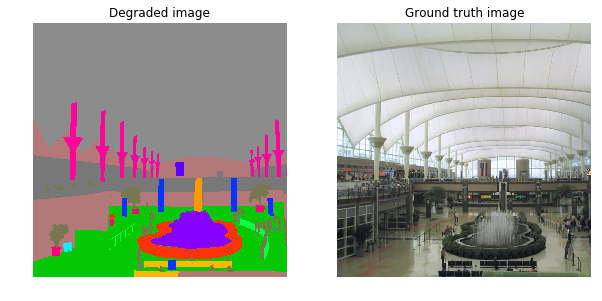

In [20]:
degradation = SegmentationDegradation(device=DEVICE)
initd = degradation.init_latent_images(label)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(initd[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[0].set_title(f'Degraded image')
ax[1].imshow(image[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');

# Minimizing objective using LBFGS

In [21]:
solver = TorchGradientOptimizer(degradation, 10, TotalVariationPrior(), 3e-4, ClampProjection(0, 1), th.optim.LBFGS,
                                lr=1, max_iter=100, history_size=250, line_search_fn='strong_wolfe')

print('INITIALIZATION: ')
print(f'Likelihood vlaue: {degradation.likelihood(label, degradation.init_latent_images(label)).cpu().numpy()}')
print(f'Prior vlaue: {solver.prior(degradation.init_latent_images(label)).cpu().numpy()}')
restored = th.clamp(solver.restore(label), 0, 1)
print('AFTER RESTORATION: ')
print(f'Likelihood vlaue: {degradation.likelihood(label, restored).cpu().numpy()}')
print(f'Prior vlaue: {solver.prior(restored).cpu().numpy()}')

INITIALIZATION: 
Likelihood vlaue: 5.05164909362793
Prior vlaue: 3.367264986038208
AFTER RESTORATION: 
Likelihood vlaue: 0.34581929445266724
Prior vlaue: 1.5302854776382446


# Visualizing result

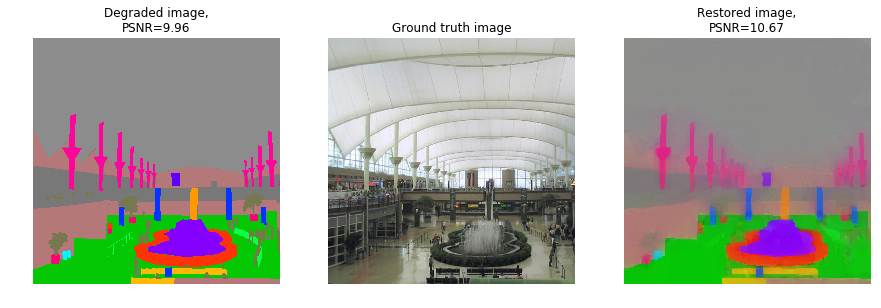

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
psnr_degraded = psnr(initd, image)
ax[0].imshow(initd[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[0].set_title(f'Degraded image,\nPSNR={str(np.round(psnr_degraded.cpu().numpy(), 2)[0])}')
ax[1].imshow(image[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');
psnr_value = psnr(restored, image)
ax[2].imshow(restored[0].permute(1,2,0).cpu())
ax[2].axis('off')
ax[2].set_title(f'Restored image,\nPSNR={str(np.round(psnr_value.cpu().numpy(), 2)[0])}');

# Run grid search to estimate optimal regularizer weight

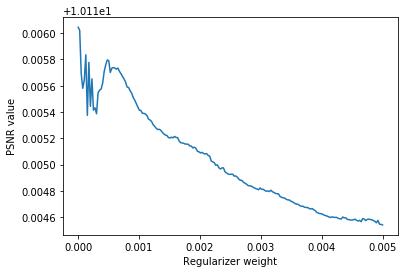

In [8]:
def grid_search(degraded_image, ground_truth_image, degradation, max_value=1e-3, num_points=100):
    candidates = np.linspace(0, max_value, num=num_points)
    psnrs = []
    for candidate in candidates:
        solver = TorchGradientOptimizer(degradation, 1, TotalVariationPrior(), candidate, ClampProjection(0, 1), th.optim.LBFGS,
                                        lr=1, max_iter=20, history_size=100, line_search_fn='strong_wolfe')
        restored = th.clamp(solver.restore(degraded_image), 0, 1)
        psnrs.append(psnr(restored, ground_truth_image).cpu().numpy())
    return candidates[np.argmax(psnrs)], candidates, psnrs

optimal_weight, candidates, psnrs_hist  = grid_search(label, image, degradation, max_value=5e-3, num_points=200)
plt.plot(candidates, psnrs_hist)
plt.xlabel('Regularizer weight')
plt.ylabel('PSNR value');

# Run restoration with optimal weight

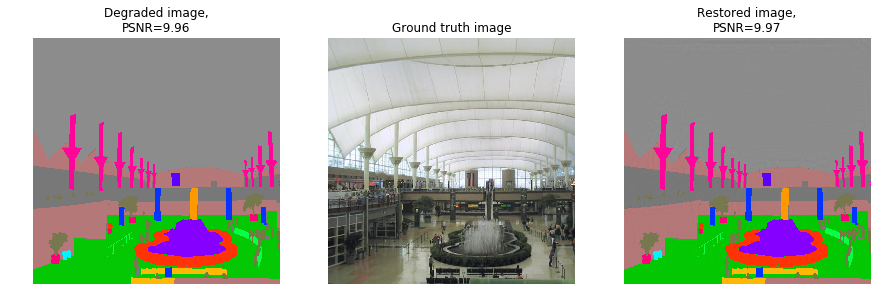

In [27]:
solver = TorchGradientOptimizer(degradation, 1, TotalVariationPrior(), optimal_weight, ClampProjection(0, 1), th.optim.LBFGS,
                                lr=1, max_iter=20, history_size=100, line_search_fn='strong_wolfe')
restored = th.clamp(solver.restore(label), 0, 1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
psnr_degraded = psnr(initd, image)
ax[0].imshow(initd[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[0].set_title(f'Degraded image,\nPSNR={str(np.round(psnr_degraded.cpu().numpy(), 2)[0])}')
ax[1].imshow(image[0].permute(1,2,0).cpu())
ax[1].axis('off')
ax[1].set_title('Ground truth image');
psnr_value = psnr(restored, image)
ax[2].imshow(restored[0].permute(1,2,0).cpu())
ax[2].axis('off')
ax[2].set_title(f'Restored image,\nPSNR={str(np.round(psnr_value.cpu().numpy(), 2)[0])}');